In [1]:
import os
import pickle
import numpy as np

import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

# load `SpenderQ` models

In [3]:
niter = 3

models = [] 
for imodel in range(1): 
    # load model
    #_models, losses = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p5sb1p5.i%i.pt' % niter)
    _models, losses = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p1sb0p8.i%i.pt' % niter)
    models.append(_models[0])

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [4]:
spec, w, z, target_id, norm = [], [], [], [], []
true_cont = [] 
recons = [] 

for ibatch in range(5): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        _spec, _w, _z, _target_id, _norm, zerr = pickle.load(f)
    spec.append(np.array(_spec))
    w.append(np.array(_w))
    z.append(np.array(_z))
    target_id.append(np.array(_target_id))    
    norm.append(np.array(_norm))

    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch)))

    # load SpenderQ recon 
    _recons = []  
    for imodel in range(5): 
        _recons.append(np.load('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.recons.npy' % (niter, imodel, ibatch)))
    recons.append(np.array(_recons))
    
spec = np.concatenate(spec, axis=0)
w = np.concatenate(w)
z = np.concatenate(z)
target_id = np.concatenate(target_id)
norm = np.concatenate(norm)

true_cont = np.concatenate(true_cont, axis=0)

recons = np.concatenate(recons, axis=1)

mean_recon = np.mean(recons, axis=0) # ensemble reconstruction

w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)    

In [5]:
picca_lya = U.london_picca('LyA')
picca_lyb = U.london_picca('LyB')

In [6]:
# load \bar{F}
#barF_rest = np.load('barF_all.npy')
barF_rest = np.load('barF_nobaldla.npy')

In [7]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []
dcont_picca_lya, dfcont_picca_lya = [], []
dcont_picca_lyb, dfcont_picca_lyb = [], []

for igal in range(len(z)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+z[igal])) & ((wave_rest_rebin < 9.9e3/float(1+z[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    # rebin reconstruction
    recon_rebin = U.trapz_rebin(
        w_recon, 
        mean_recon[igal], 
        xnew=wave_rest_rebin[wlim])
    
    # residual
    dcont = np.repeat(-999., len(wave_rest_rebin))
    dcont[wlim] = true_rebin - recon_rebin 
    
    # fractional residual
    dfcont = np.repeat(-999., len(wave_rest_rebin))
    dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin

    dcont_recon.append(dcont)
    dfcont_recon.append(dfcont)
    
    
    # picca
    # rebinning for picca
    wlim = (wave_rest_rebin > np.max([1040, 3.6e3/float(1+z[igal])])) & (wave_rest_rebin < 1195)
    
    fpicca = picca_lya.get_continuum(int(target_id[igal]))
    if fpicca is not None: 
        # rebin true continuum
        true_rebin = U.trapz_rebin(
            np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
            np.array(true_cont[igal]/norm[igal]), 
            xnew=wave_rest_rebin[wlim])
        
        # rebin picca
        fpicca /= np.array(norm[igal])
        picca_rebin = U.trapz_rebin(
            picca_lya.wave_picca, 
            fpicca, 
            xnew=wave_rest_rebin[wlim])
        
        dcont = np.repeat(-999., len(wave_rest_rebin))
        #dcont[wlim] = barF_rest[wlim] * true_rebin - picca_rebin 
        dcont[wlim] = true_rebin - picca_rebin 
            
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        #dfcont[wlim] = (barF_rest[wlim] * true_rebin - picca_rebin)/true_rebin
        dfcont[wlim] = (true_rebin - picca_rebin)/true_rebin
    else:
        # no picca
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont = np.repeat(-999., len(wave_rest_rebin))
    
    dcont_picca_lya.append(dcont)
    dfcont_picca_lya.append(dfcont)

    # rebinning for picca LyB
    wlim = (wave_rest_rebin > np.max([920, 3.6e3/float(1+z[igal])])) & (wave_rest_rebin < 1020)
    
    fpicca = picca_lyb.get_continuum(int(target_id[igal]))
    if fpicca is not None and np.sum(wlim) > 0: 
        # rebin true continuum
        true_rebin = U.trapz_rebin(
            np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
            np.array(true_cont[igal]/norm[igal]), 
            xnew=wave_rest_rebin[wlim])
        
        # rebin picca
        fpicca /= np.array(norm[igal])
        picca_rebin = U.trapz_rebin(
            picca_lyb.wave_picca, 
            fpicca, 
            xnew=wave_rest_rebin[wlim])
        
        dcont = np.repeat(-999., len(wave_rest_rebin))
        #dcont[wlim] = barF_rest[wlim] * true_rebin - picca_rebin 
        dcont[wlim] = true_rebin - picca_rebin 
            
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        #dfcont[wlim] = (barF_rest[wlim] * true_rebin - picca_rebin)/true_rebin
        dfcont[wlim] = (true_rebin - picca_rebin)/true_rebin        
    else:
        # no picca
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        
    dcont_picca_lyb.append(dcont)
    dfcont_picca_lyb.append(dfcont)
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

dcont_picca_lya = np.array(dcont_picca_lya)
dfcont_picca_lya = np.array(dfcont_picca_lya)

dcont_picca_lyb = np.array(dcont_picca_lyb)
dfcont_picca_lyb = np.array(dfcont_picca_lyb)

negative slope
no fit
no fit
negative slope
no fit
negative slope
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no f

no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
negative slope
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no f

no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no 

In [8]:
picca_fail_lya = np.all(dcont_picca_lya == -999, axis=1)
print(np.mean(picca_fail_lya))

0.035546875


In [9]:
picca_fail_lyb = np.all(dcont_picca_lyb == -999, axis=1)
print(np.mean(picca_fail_lyb))

0.6998046875


In [11]:
# spenderq performance on QSO with picca 
dcont_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.)# & ~picca_fail_lya

    if np.sum(has_spectra): 
        dcont_q[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])     
        
# spenderq performance on QSO without picca 
dcont_q_nopicca = np.zeros((len(wave_rest_rebin), 5))
dfcont_q_nopicca = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & picca_fail_lya

    if np.sum(has_spectra): 
        dcont_q_nopicca[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q_nopicca[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])         

# spenderq performance on QSO without picca lyb
dcont_q_nopicca_lyb = np.zeros((len(wave_rest_rebin), 5))
dfcont_q_nopicca_lyb = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & picca_fail_lyb

    if np.sum(has_spectra): 
        dcont_q_nopicca_lyb[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q_nopicca_lyb[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])                 
        
# picca performance on QSO with picca        
dcont_picca_lya_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_picca_lya_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_picca_lya[:,i] != -999.) & ~picca_fail_lya

    if np.sum(has_spectra): 
        dcont_picca_lya_q[i,:] = np.quantile(dcont_picca_lya[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_picca_lya_q[i,:] = np.quantile(dfcont_picca_lya[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])        

# picca lyb performance on QSO with picca lyb
dcont_picca_lyb_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_picca_lyb_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_picca_lyb[:,i] != -999.) & ~picca_fail_lyb

    if np.sum(has_spectra): 
        dcont_picca_lyb_q[i,:] = np.quantile(dcont_picca_lyb[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_picca_lyb_q[i,:] = np.quantile(dfcont_picca_lyb[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])                

Text(0.5, 0, 'rest-frame wavelength')

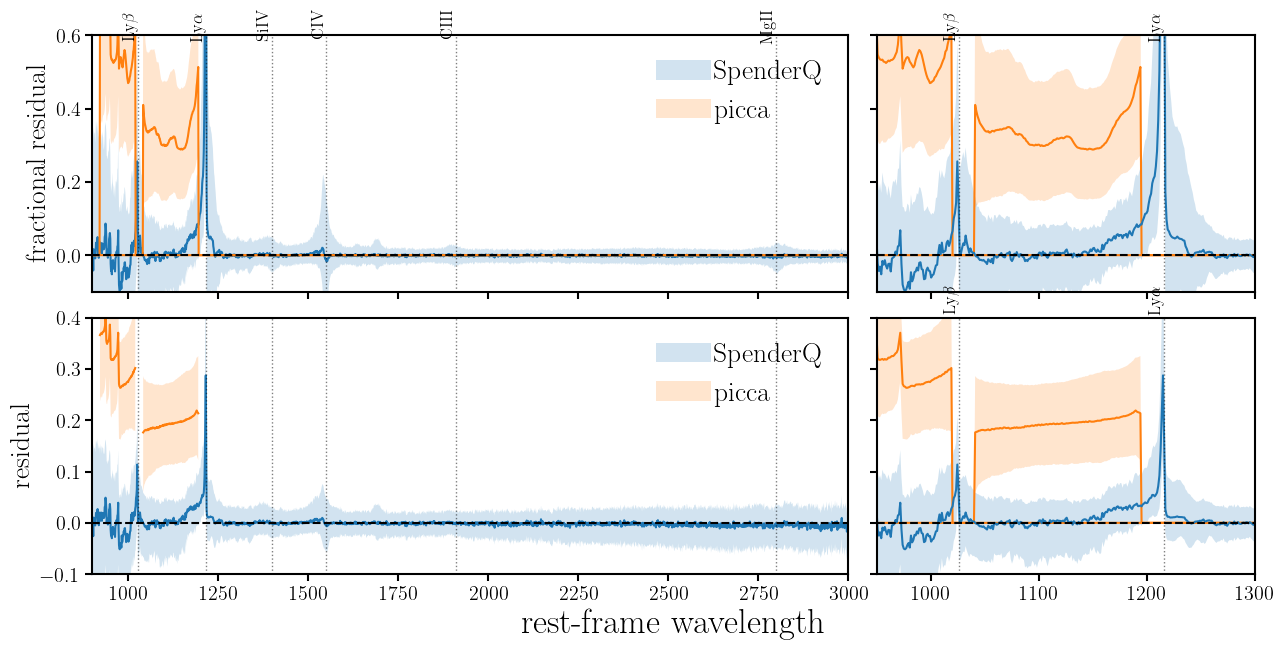

In [12]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1]) 

# fractional residual
sub = plt.subplot(gs[0])

# SpenderQ
sub.fill_between(wave_rest_rebin, dcont_q[:,1], dcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dcont_q[:,2], color='C0')

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] != -999)
sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,1][wlim], dcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,2][wlim], color='C1')
# picca LyA
wlim = (dfcont_picca_lya_q[:,2] != -999)
sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lya_q[:,1][wlim], dcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dcont_picca_lya_q[:,2][wlim], color='C1')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.text(1026, 0.66, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.66, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 0.67, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 0.67, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 0.67, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 0.67, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_xticklabels([])
sub.set_ylabel('fractional residual', fontsize=20)
sub.set_ylim(-0.1, 0.6)

sub = plt.subplot(gs[1])

wlim = (dfcont_picca_lyb_q[:,2] != -999)
sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,1][wlim], dcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_lya_q[:,2] != -999)

sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lya_q[:,1][wlim], dcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dcont_picca_lya_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, dcont_q[:,1], dcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, dcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.66, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.66, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_xticklabels([])
sub.set_ylim(-0.1, 0.6)
sub.set_yticklabels([])

# fractional residual
sub = plt.subplot(gs[2])

# SpenderQ
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')
# picca LyA
wlim = (dfcont_picca_lya_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,1][wlim], dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,2][wlim], color='C1')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_ylabel('residual', fontsize=20)
sub.set_ylim(-0.1, 0.4)

sub = plt.subplot(gs[3])

wlim = (dfcont_picca_lyb_q[:,2] != -999.)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_lya_q[:,2] != -999.)

sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,1][wlim], dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.46, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.46, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_ylim(-0.1, 0.4)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)

Text(0.5, 0, 'rest-frame wavelength [\\r{A}]')

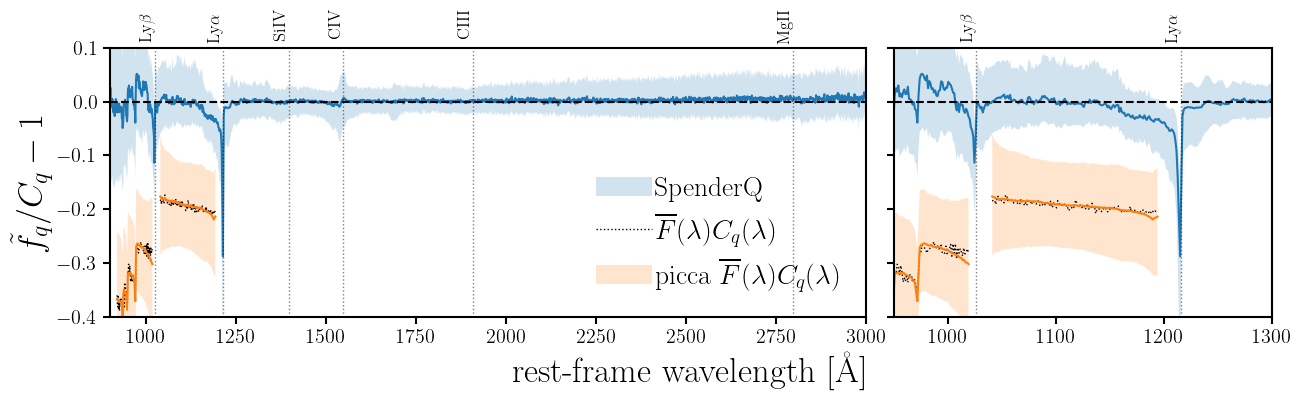

In [13]:
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# fractional residual
sub = plt.subplot(gs[0])

# SpenderQ
sub.fill_between(wave_rest_rebin, -dfcont_q[:,1], -dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, -dfcont_q[:,2], color='C0')

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] != -999.) & (dfcont_picca_lyb_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1, label='$\overline{F}(\lambda)C_q(\lambda)$')

sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,1][wlim], -dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label=r'picca $\overline{F}(\lambda)C_q(\lambda)$')
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,2][wlim], color='C1')

# picca LyA
wlim = (dfcont_picca_lya_q[:,2] != -999.) & (dfcont_picca_lya_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1)
sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,1][wlim], -dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,2][wlim], color='C1')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.text(1026, 0.16, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.16, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 0.17, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 0.17, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 0.17, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 0.17, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='lower right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
#sub.set_xticklabels([])
sub.set_ylabel(r'$\tilde{f}_q/C_q-1$', fontsize=25)
sub.set_ylim(-0.4, 0.1)

sub = plt.subplot(gs[1])

# LyB
wlim = (dfcont_picca_lyb_q[:,2] != -999.) & (dfcont_picca_lyb_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1)
sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,1][wlim], -dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,2][wlim], color='C1')

# LyA
wlim = (dfcont_picca_lya_q[:,2] != -999.) & (dfcont_picca_lya_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1)
sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,1][wlim], -dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, -dfcont_q[:,1], -dfcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, -dfcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.16, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.16, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
#sub.set_xticklabels([])
sub.set_ylim(-0.4, 0.1)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel(r'rest-frame wavelength [\r{A}]', fontsize=25)

#plt.savefig('recon_resid.pdf', bbox_inches='tight')

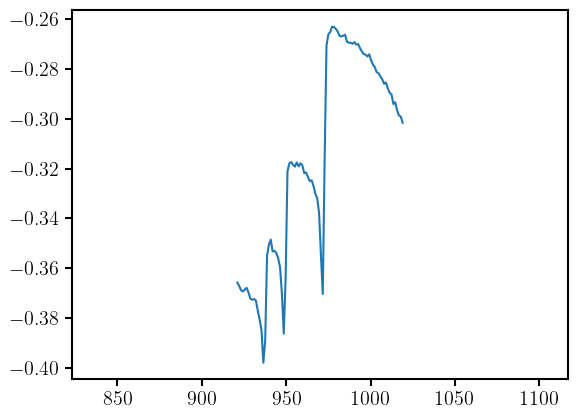

In [23]:
wlim = (dfcont_picca_lyb_q[:,2] != -999.) & (dfcont_picca_lyb_q[:,2] != 0.) & (wave_rest_rebin > 920) & (wave_rest_rebin < 1020)

plt.plot(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,2][wlim])


0.31770811864324455
0.19284194587240766


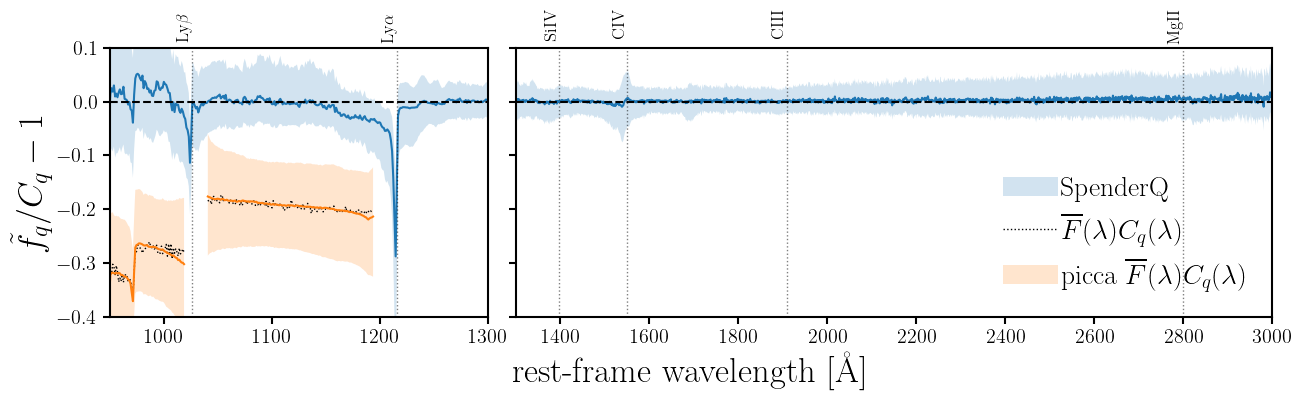

In [21]:
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

# fractional residual
sub = plt.subplot(gs[1])

# SpenderQ
sub.fill_between(wave_rest_rebin, -dfcont_q[:,1], -dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, -dfcont_q[:,2], color='C0')

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] != -999.) & (dfcont_picca_lyb_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1, label='$\overline{F}(\lambda)C_q(\lambda)$')

sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,1][wlim], -dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label=r'picca $\overline{F}(\lambda)C_q(\lambda)$')
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,2][wlim], color='C1')

# picca LyA
wlim = (dfcont_picca_lya_q[:,2] != -999.) & (dfcont_picca_lya_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1)
sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,1][wlim], -dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,2][wlim], color='C1')

print(np.median(dfcont_picca_lya_q[:,2][wlim]))

sub.axhline(0., color='k', linestyle='--')

#sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
#sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

#sub.text(1026, 0.16, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
#sub.text(1216, 0.16, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 0.17, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 0.17, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 0.17, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 0.17, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='lower right', handletextpad=0.1, fontsize=20)
sub.set_xlim(1300., 3000.)
#sub.set_xlim(900., 3000.)
#sub.set_xticklabels([])
#sub.set_ylabel(r'$\tilde{f}_q/C_q-1$', fontsize=25)
sub.set_ylim(-0.4, 0.1)
sub.set_yticklabels([])

sub = plt.subplot(gs[0])

# LyB
wlim = (dfcont_picca_lyb_q[:,2] != -999.) & (dfcont_picca_lyb_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1)
sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,1][wlim], -dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lyb_q[:,2][wlim], color='C1')

# LyA
wlim = (dfcont_picca_lya_q[:,2] != -999.) & (dfcont_picca_lya_q[:,2] != 0.)
sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', lw=1)
sub.fill_between(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,1][wlim], -dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lya_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, -dfcont_q[:,1], -dfcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, -dfcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.16, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.16, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
#sub.set_xticklabels([])
sub.set_ylabel(r'$\tilde{f}_q/C_q-1$', fontsize=25)
sub.set_ylim(-0.4, 0.1)
#sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel(r'rest-frame wavelength [\r{A}]', fontsize=25)

plt.savefig('recon_resid.pdf', bbox_inches='tight')

In [14]:
# data for DESI data management plan

output = {}

# spenderq
output['spenderq_wave'] = wave_rest_rebin
output['spenderq_dfcont_q'] = -dfcont_q

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] != -999.) & (dfcont_picca_lyb_q[:,2] != 0.)
output['picca_lyb_wave'] = wave_rest_rebin[wlim]
output['picca_lyb_barF_true'] = barF_rest[wlim] - 1.
output['picca_lyb_dfcont_q'] = -dfcont_picca_lyb_q[wlim]

# picca LyA
wlim = (dfcont_picca_lya_q[:,2] != -999.) & (dfcont_picca_lya_q[:,2] != 0.)
output['picca_lya_wave'] = wave_rest_rebin[wlim]
output['picca_lya_barF_true'] = barF_rest[wlim] - 1.
output['picca_lya_dfont_q'] = -dfcont_picca_lya_q[wlim]

import pickle

with open('fig3.p', 'wb') as f: pickle.dump(output, f)

(-0.1, 0.1)

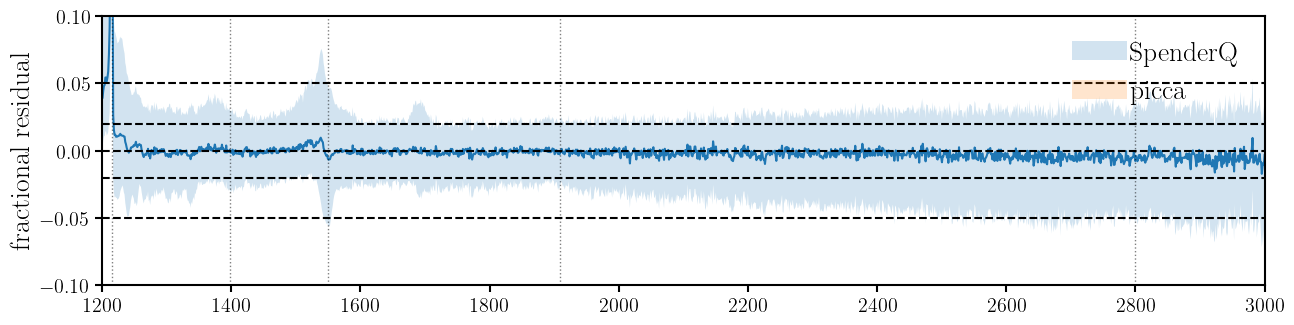

In [15]:
fig = plt.figure(figsize=(15,3.5))
sub = fig.add_subplot(111)

# SpenderQ
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')
# picca LyA
wlim = (dfcont_picca_lya_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,1][wlim], dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,2][wlim], color='C1')

sub.axhline(0., color='k', linestyle='--')
sub.axhline(0.02, color='k', linestyle='--')
sub.axhline(0.05, color='k', linestyle='--')
sub.axhline(-0.02, color='k', linestyle='--')
sub.axhline(-0.05, color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

# sub.text(1026, 0.46, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
# sub.text(1216, 0.46, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
# sub.text(1397.61, 0.47, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
# sub.text(1549.48, 0.47, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
# sub.text(1908.73, 0.47, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
# sub.text(2799.12, 0.47, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(1200., 3000.)
sub.set_ylabel('fractional residual', fontsize=20)
sub.set_ylim(-0.1, 0.1)

# fractional residual for no picca

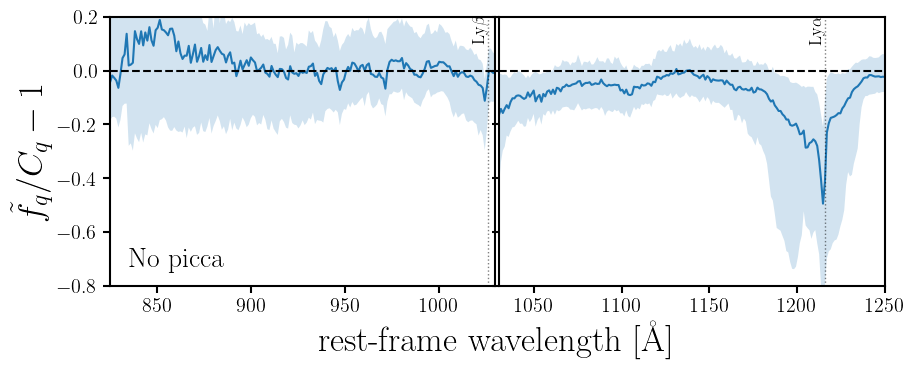

In [14]:
fig = plt.figure(figsize=(10,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

# fractional residual
sub = plt.subplot(gs[0])
sub.fill_between(wave_rest_rebin, -dfcont_q_nopicca_lyb[:,1], -dfcont_q_nopicca_lyb[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, -dfcont_q_nopicca_lyb[:,2], color='C0')

sub.axhline(0., color='k', linestyle='--')
sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.2, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(0.05, 0.05, 'No picca', transform=sub.transAxes, ha='left', va='bottom', fontsize=20)

sub.set_xlim(825., 1030.)

sub.set_ylim(-0.8, 0.2)
sub.set_ylabel(r'$\tilde{f}_q/C_q - 1$', fontsize=25)

# fractional residual
sub = plt.subplot(gs[1])
sub.fill_between(wave_rest_rebin, -dfcont_q_nopicca[:,1], -dfcont_q_nopicca[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, -dfcont_q_nopicca[:,2], color='C0')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1216, 0.2, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(1030., 1250.)
sub.set_xticks([1050, 1100, 1150, 1200, 1250])

sub.set_ylim(-0.8, 0.2)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.01)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel(r'rest-frame wavelength [\r{A}]', fontsize=25)

plt.savefig('recon_resid_nopicca.pdf', bbox_inches='tight')

In [16]:
# DESI DMP
output = {} 

output['spenderq_wave'] = wave_rest_rebin
output['spenderq_dfont_q_nolybpicca'] = -dfcont_q_nopicca_lyb
output['spenderq_dfont_q_nolyapicca'] = -dfcont_q_nopicca

with open('fig4.p', 'wb') as f: pickle.dump(output, f)

# individual reconstructions

/tmp/ipykernel_4115029/3370118811.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


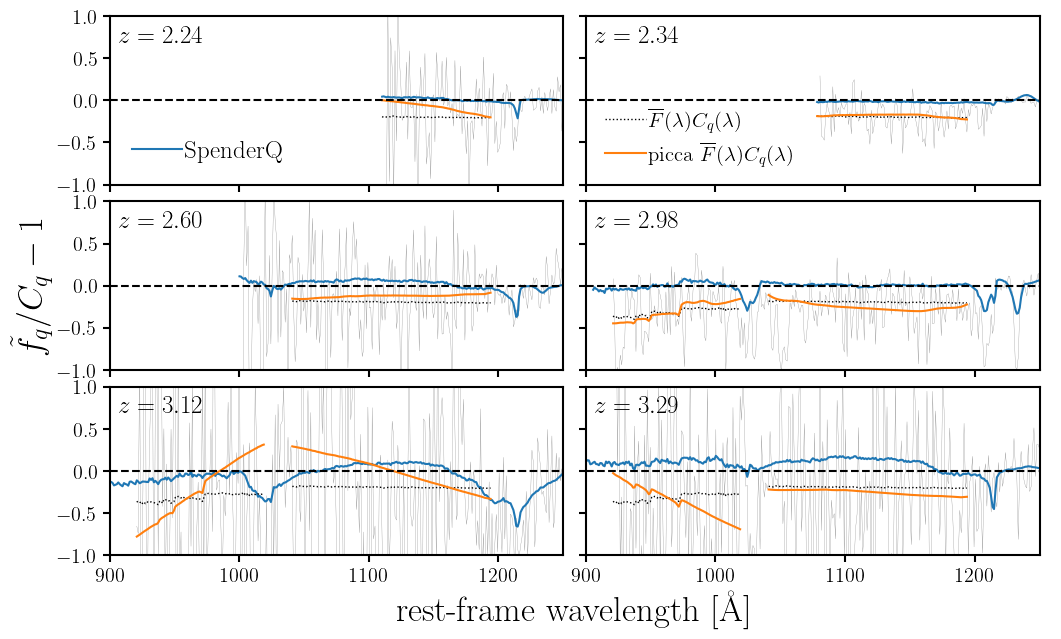

In [19]:
fig = plt.figure(figsize=(12,7))

#zbins = np.linspace(2.1, 3.5, 7)
#igals = [] 
#for i in range(6): 
#    igals.append(np.random.choice(np.arange(len(spec))[(z > zbins[i]) & (z < zbins[i+1])], size=1)[0])
#igals = np.array(igals)
#print(igals)
#igals = igals[np.argsort(np.array(z)[igals])]

igals = [3656, 2162, 4399, 449, 724, 952]

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(igals):
    sub = fig.add_subplot(3, 2, ii+1)
    
    wlim = (wave_rest_rebin > np.max([920, 3610/float(1+z[igal])])) & (wave_rest_rebin < np.min([1300, 9800/(1.+np.array(z)[igal])]))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    _spec_rebin = U.trapz_rebin(
            np.array(models[0].wave_obs)/(1.+np.array(z)[igal]), 
            np.array(spec[igal]), 
            xnew=wave_rest_rebin[wlim])
    
    sub.plot(wave_rest_rebin[wlim], (_spec_rebin-true_rebin)/true_rebin, c='k', lw=0.2, alpha=0.5)
    
    # SpenderQ
    wlim = (dcont_recon[igal] > -999)
    sub.plot(wave_rest_rebin[wlim], -dfcont_recon[igal][wlim], label=[None, 'SpenderQ'][ii == 0])

    # picca LyA
    wlim = (dcont_picca_lya[igal] > -999)    
    sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', linewidth=1, 
             label=[None, '$\overline{F}(\lambda)C_q(\lambda)$'][ii == 1])
    sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lya[igal][wlim], color='C1', label=[None, 'picca $\overline{F}(\lambda)C_q(\lambda)$'][ii == 1])
    
    # picca LyB
    wlim = (dcont_picca_lyb[igal] > -999)
    sub.plot(wave_rest_rebin[wlim], barF_rest[wlim] - 1., color='k', linestyle=':', linewidth=1)
    sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lyb[igal][wlim], color='C1')
    
    sub.axhline(0., color='k', linestyle='--')
    
    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=18, transform=sub.transAxes)

    sub.set_xlim(900., 1250.)#models[0].wave_rest[-1])
    sub.set_xticks([900, 1000, 1100, 1200])
    sub.set_ylim(-1, 1.)
    if ii < 4: sub.set_xticklabels([])
    if ii in [1, 3, 5]: sub.set_yticklabels([])
    if ii == 0: sub.legend(loc='lower left', fontsize=18, handletextpad=0.1)
    if ii == 1: sub.legend(loc='lower left', fontsize=15, handletextpad=0.1)
    if ii == 2: sub.set_ylabel(r'$\tilde{f}_q/C_q - 1$', fontsize=25)
        
fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel(r'rest-frame wavelength [\r{A}]', fontsize=25)

plt.savefig('recon_resid_indiv.pdf', bbox_inches='tight')

In [18]:
# DESI DMP 
output = {} 
output['redshift'] = [] 
output['mock_wave'] = []
output['mock_dfcont'] = []
output['spenderq_wave'] = []
output['spenderq_dfcont'] = []
output['picca_lya_wave'] = [] 
output['picca_lya_barF'] = [] 
output['picca_lya_dfont'] = [] 
output['picca_lyb_wave'] = [] 
output['picca_lyb_barF'] = [] 
output['picca_lyb_dfont'] = [] 

igals = [3656, 2162, 4399, 449, 724, 952]
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(igals):
    output['redshift'].append(z[igal])
    
    wlim = (wave_rest_rebin > np.max([920, 3610/float(1+z[igal])])) & (wave_rest_rebin < np.min([1300, 9800/(1.+np.array(z)[igal])]))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    _spec_rebin = U.trapz_rebin(
            np.array(models[0].wave_obs)/(1.+np.array(z)[igal]), 
            np.array(spec[igal]), 
            xnew=wave_rest_rebin[wlim])
    
    output['mock_wave'].append(wave_rest_rebin[wlim])
    output['mock_dfcont'].append((_spec_rebin-true_rebin)/true_rebin)
    
    
    # SpenderQ
    wlim = (dcont_recon[igal] > -999)
    output['spenderq_wave'].append(wave_rest_rebin[wlim])
    output['spenderq_dfcont'].append(-dfcont_recon[igal][wlim])

    # picca LyA
    wlim = (dcont_picca_lya[igal] > -999)    
    output['picca_lya_wave'] = wave_rest_rebin[wlim]
    output['picca_lya_barF'] = barF_rest[wlim] - 1. 
    output['picca_lya_dfcont'] = -dfcont_picca_lya[igal][wlim]
    
    # picca LyB
    wlim = (dcont_picca_lyb[igal] > -999)
    output['picca_lyb_wave'] = wave_rest_rebin[wlim]
    output['picca_lyb_barF'] = barF_rest[wlim] - 1.
    output['picca_lyb_dfcont'] = -dfcont_picca_lyb[igal][wlim]
    
with open('fig5.p', 'wb') as f: 
    pickle.dump(output, f)

/tmp/ipykernel_1094113/424549484.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
